# Local Invariant Features for Object Detection
## Computer Vision and Image Processing - Lab Session 6
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Pierluigi Zama Ramirez, pierluigi.zama@unibo.it

## Correspondences 
A great variety of computer vision problems can be dealt with finding corresponding points between images. 
Corresponding (or homologous) points: image points which are the projection of the same 3D position from different points of view. Being projection their appearance can vary greatly between one image and the other so establishing correspondences may be difficult.

<img src="LabSession6Images/correspondences.png" width="512">

## Tasks using Correspondences

### Augmented Reality

<img src="LabSession6Images/AR.png" width="512">

### 3D Reconstruction

<img src="LabSession6Images/3Dreconstruction.png" width="512">

### Object Detection

<img src="LabSession6Images/object_detection.png" width="512">

### Mosaicing (a.k.a. panorama photo)

<img src="LabSession6Images/panorama.png" width="512">

### SLAM

<img src="LabSession6Images/slam.png" width="512">

### Visual Search

<img src="LabSession6Images/visual_search.png" width="512">

### Object Detection

detect instances of objects in images (scenes), given one or more reference image depicting them (models).

<img src="LabSession6Images/object_detection_2.png" width="768">

**What can go wrong? What a good detection system should handle?**

* **Scale invariance**: object in scene may appear at any scale, not only at the same resolution used for the model images.
* **Rotation invariance**: object may appear rotated or skewed in the scene.
* **Photometric invariance**: object may appear in any light condition.
* **Occlusion**: portion of the objects may not be visible in the scene.
* **Perspective distortion**: Object may appear fairly different if viewed from different camera viewpoint

### Object Detection with CNN
State of the art methods are based on machine learning, especially convolutional neural networks (i.e. CNN).
* Pro:Astonishing real time performances for the detection of complex and highly variable categories of objects (persons, animals, vehicles...)
* Cons: Requires thousand of model images for each category of objects we want to recognize and a lot of time to train the algorithm.

<img src="LabSession6Images/object_detection_cnn.png" width="512">


### Local Invariant Features Paradigm: State of the art approach before the Machine learning revolution. 

Proposed by David Lowe in 2004[4], allows to successfully identify objects in scene from a 
single model image per object.

**Pros:**
* Quite effective for the detection of textured objects.
* Scale/rotation and illuminance invariance.
* Works under partial occlusion.
* Only one model image per object required.
* Fully implementable in openCV with few lines of code.

**Cons**:
* Suffers from changes in camera viewpoint.
* Can be slow when the number of objects to recognize increases
* Does not work well with deformable objects or to detect categories of objects.

**Four steps**:
1. **Detection**: Identify salient repeatable points (Keypoints) in model and scene images.
2. **Description**: Create a unique description of each point, usually based on its local pixel neighborhood.
3. **Matching**: Match point from scene and model according to a similarity function between the descriptors.
4. **Position Estimation**: Estimate the position of the object in the scene image given enough matching points 

Let us now try to implement an object detection pipeline. We will use SIFT detector and descriptor in this example. Let us first import the needed Python libraries:

In [7]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

Let us load a train image:

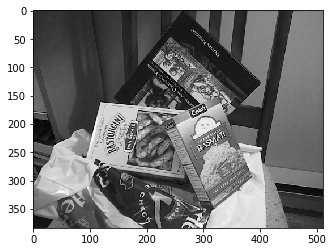

In [4]:
img_train = cv2.imread('LabSession6Images/box_in_scene.png',0) # trainImage
plt.imshow(img_train, cmap='gray',vmin=0,vmax=255)
plt.show()

And a query image:

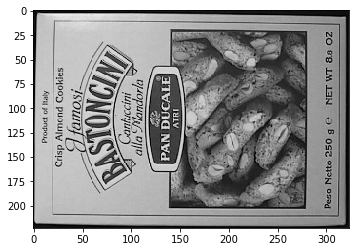

In [6]:
img_query = cv2.imread('LabSession6Images/box.png',0) # queryImage
plt.imshow(img_query, cmap='gray',vmin=0,vmax=255)
plt.show()

### 1. Keypoint Detection

Common schema:

1. Compute a saliency score for each pixel location based on the response to different mathematical operators. 
2. Keep only the points that are local maxima.
3. For each keypoint estimate the ‘scale’ at which it is salient (scale invariance) and the orientation (rotation invariance).   

Let us now find keypoints in the scene based on the sift detector. We first initialize the SIFT detector object in the following way:


In [9]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

Then we need to find keypoints. We will use _detect_ method of the SIFT detector object. Let us find the keypoints of the query image:

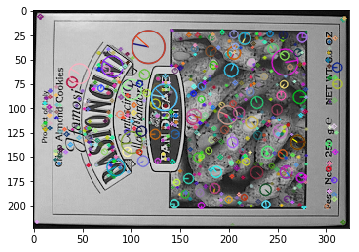

In [12]:
# find the keypoints and descriptors with SIFT
kp_query = sift.detect(img_query)

# Visualize keypoints with drawKeypoints.
#Use flag DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS to show scale and orientation of keypoints.
img_visualization = cv2.drawKeypoints(img_query,kp_query,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization)
plt.show()

and train image:

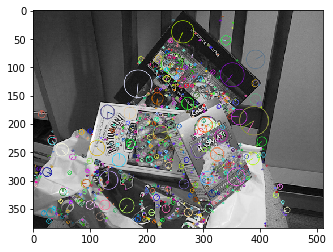

In [16]:
kp_train = sift.detect(img_train)

img=cv2.drawKeypoints(img_train,kp_train,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()

kp_query, des_query = sift.compute(img_query,kp_query)

### 2. Keypoints Description 

Compute for each keypoint a unique description usually based on the nearby pixels (descriptor support).

A good keypoint descriptor should be:
* Repeatable: the descriptions computed at homologus points should be as similar as possible.
* Distinctive: capture the salient informations around the keypoint despite various nuisances (e.g. light changes). 
* Compact: minimize memory occupancy to allow efficient matching.
* Fast: it is usually applied to hundred or thousand of keypoints in each image.

**Given the patch surrounding a keypoint, can we use raw pixel intensities as descriptor?**

Different algorithms provides different descriptions, the common idea is to describe keypoints using an array (histogram) of values that encodes the appearance of its local neighborhood. The size of the support depends on the scale associated to the keypoint (i.e. scale invariance). 
The descriptor are computed according to the orientation associated to the  keypoint (i.e rotation invariance).

The histogram used for the description could be made of:
* floats: more distinctive, high memory footprint 
* bits: less distinctive, small memory footprint (binary descriptors)

Some well known algorithms:
1. **SIFT**: 128 floats array (4.096 bytes for each descriptor)
2. **SURF**: 64 floats array (2.048 bytes for each descriptor)
3. **BRISK**:  512 bit array (64 bytes for each descriptor)
4. **ORB**: 256 bit array (32 bytes for each descriptor)

<img src="LabSession6Images/keypoint_description.png" width="768">

We will use the SIFT descriptor for this sample study. We can use the same SIFT detector object calling the *compute* method:

In [30]:
# Describing keypoints for query and train images
kp_query, des_query = sift.compute(img_query, kp_query)
kp_train, des_train = sift.compute(img_train, kp_train)

### 3. Feature Matching

Descriptors extracted from the scene are compared with those extracted from the models to find couples of similar ones. Classic Nearest Neighbour(NN) Search problem: Given a set of points $n$ points $R=\{r_0,...,r_n\}$, a query point $q$ and a distance function $D$; find the point $r_{nn} \in R$ such that:

$D(q,r_{nn})<D(q,r_k), \forall r_k \in R$

In our scenario points are feature vectors and the distance function is Euclidean distance for floats or 
Hamming distance for bits. 


Naive idea - Brute force matcher: 
For each keypoint $q$ detected in scene compute all the $D(q,r_{nn})$ to find the minimum. Too slow to be applied in a lot of application, may sometimes be used with binary descriptor (distance function is a simple XOR between the descriptors). 

Smart idea - indexing technique:
Use efficient indexing techniques borrowed from database management to speed up the search:
* Kd-tree - exact
* BBF - approximated
* LSH - for binary descriptor

A simple case study: kd-tree with two dimension

<img src="LabSession6Images/kdtree.png" width="512">

One time cost to build the tree, logaritmic number of distances to compute for each $q$.

Kd-tree may be thought of as partitioning the space into ‘bins’, during backtracking the bins adjacent to the one containing the found leaf may be examined. However the number of bins grow exponentially with the dimension of the space, so kd-tree does not work well for highly dimensional space.

Features space are highly dimensional!

<img src="LabSession6Images/kdtree_dimensionality.png" width="512">

Approximate technique helps speeding up the search.

<img src="LabSession6Images/matching.png" width="512">

To asses the performance of the matching process we can use Precision-Recall or (1-Precision)-Recall curves. Given $TP$ number of correct matches, $FP$ number of false positive matches and $P$ max number of possible matches we can define:

$Precision = \frac{TP}{TP+FP}$ $Recall = \frac{TP}{P}$

<img src="LabSession6Images/precision-recall.png" width="256">

As long as one tries to gather more matches these become less precise.

In [ ]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

### 4. Position Estimation

How can we find the position of the object in scene? (hint: did you remember camera calibration?) 

To find the position we have to compute, given the correspondences, a suitable transformation that brings points from the model reference system to the scene one.

Homography: transformation that relates any two images of the same planar surface under the pinhole camera model. An homography is a $3x3$ matrix that transforms points expressed in homogeneous coordinates; it can be decomposed in a rotation, a translation and a perspective distortion.

Given corresponding couples of points $(m,s) \in R^2$ with $m \in C_m$ and $s \in C_s$ estimate an homography means solving a linear system

<img src="LabSession6Images/homography.png" width="256">

Usually those systems are over-constrained problems with no exact solution: solve minimizing error with the least square solution.

Bounding box obtained by transforming the corner of the model image in the scene image reference system. Homography computed using least square solution.

<img src="LabSession6Images/bounding_box.png" width="512">

Problem:
some of the match are completely wrong! The estimate homography can be quite bad... Use  Random Sample Consensus (RANSAC), an algorithm to fit a parametric model to noisy data. In our case estimate an 
homography from good matches while identifying and discarding the wrong ones.

**Ransac** main idea:
Given a set of observation $O=\{o_1...o_n\}$ and a certain parametric model $M$, repeat iteratively:
1. Pick a random (small) subset $I$ of $O$ called inlier set.
2. Fit a model $M_i$ according to the observations in $I$.
3. Test all the other observations against $M_i$, add to a new set $C$ (consensus set) all the observations that fit $M_i$ according to a model specific loss function.
4. If the consensus set is bigger than the one associated with the current best model $M_b$, proceed to step 5, other way return to step 1.
5. Re-compute $M_i$ according to the observations in $I \cup C$, then set $M_b=M_i$. Restart from step 1. 

The procedure is repeated for a fixed amount of steps, at the end the best model is returned.

A simple example of RANSAC used to fit a line to a set of 2D point with Euclidean distance as loss function.
In blue $M_i$, in green $M_b$. In our case homography as parametric model, and reprojection error as loss function.

<img src="LabSession6Images/ransac.png" width="256">

Bounding box obtained by transforming the corner of the model image in the scene image reference system. Homography computed using RANSAC

<img src="LabSession6Images/bounding_box_ransac.png" width="512">


Now we set a condition that atleast 10 matches (defined by MIN_MATCH_COUNT) are to be there to find the object. Otherwise simply show a message saying not enough matches are present.

If enough matches are found, we extract the locations of matched keypoints in both the images. They are passed to find the perpective transformation. Once we get this 3x3 transformation matrix, we use it to transform the corners of queryImage to corresponding points in trainImage. Then we draw it. 

In [ ]:
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()